# <span style="color:darkviolet; font-size:50px">**Práctica: Glaucoma Classification Datasets**</span>
## Con la base de datos de **ACRIMA** de **Kaggle**

# <span style="color:violet; font-size:28px"> *Álvaro González Sánchez*
#### Modelos de Redes Neuronales, **Máster en Metodología de las Ciencias del Comportamiento y de la Salud**

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Rutas
train_dir = '/Users/alvarogonzalez/Desktop/ACRIMA backup/PARTITIONED/Training'
test_dir = '/Users/alvarogonzalez/Desktop/ACRIMA backup/PARTITIONED/Testing'

# Parámetros
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 564 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


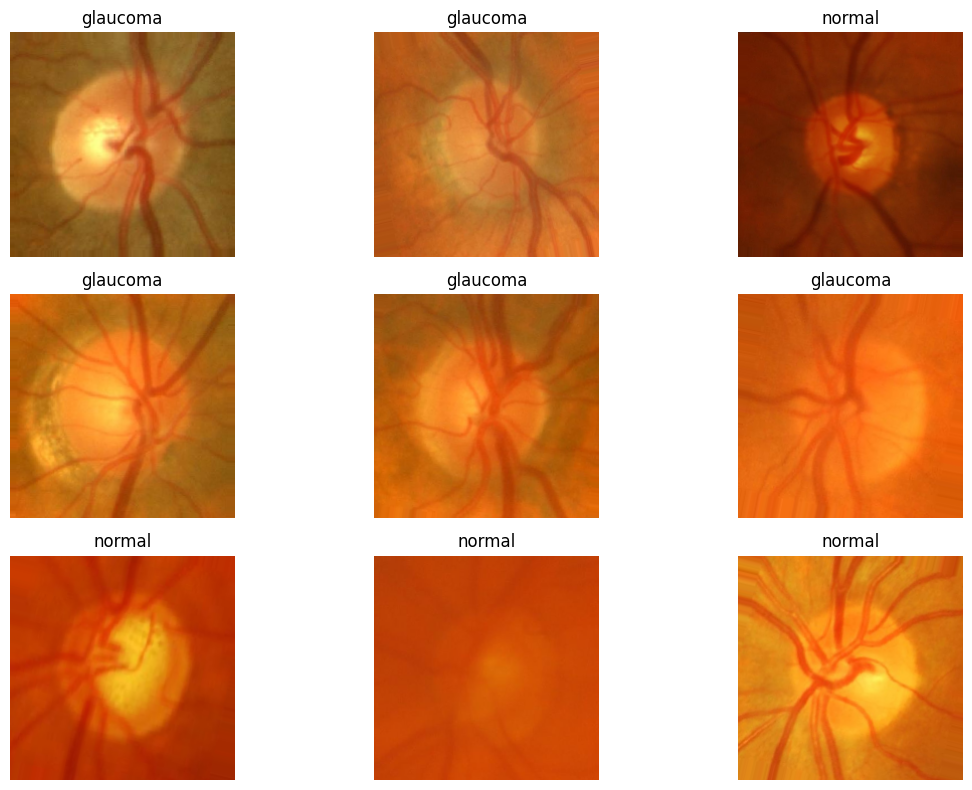

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Diccionario para convertir etiquetas numéricas a texto
class_names = {0: "normal", 1: "glaucoma"}

# Función inversa para VGG16
def reverse_preprocess_vgg16(x):
    x = x.copy()
    x += [103.939, 116.779, 123.68]  # invertir normalización
    x = x[..., ::-1]  # BGR → RGB
    return np.clip(x / 255.0, 0, 1)

# Obtener imágenes y etiquetas del generador
imgs, labels = next(train_generator)

# Número de imágenes a mostrar
n = 9
cols = 3
rows = n // cols

plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    img_vis = reverse_preprocess_vgg16(imgs[i])
    plt.imshow(img_vis)
    plt.title(class_names[int(labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

# **USAMOS LA BASE PREENTRENADA SIN CONGELAR NI TOCAR NADA**

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# 1. Cargar VGG16 sin la parte superior, con pesos de ImageNet
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# 2. Congelar TODAS las capas
for layer in base_model.layers:
    layer.trainable = False

# 3. Añadir una cabeza de clasificación mínima
x = base_model.output
x = Flatten()(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# 4. Compilar (pero no entrenar)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


2025-05-26 18:03:21.454344: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-26 18:03:21.454522: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-26 18:03:21.454538: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-26 18:03:21.455316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 18:03:21.455832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"Precisión del modelo VGG16 preentrenado sin reentrenar: {acc * 100:.2f}%")

/opt/anaconda3/envs/keras_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-26 18:03:25.027395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.4513 - loss: 2.2815
Precisión del modelo VGG16 preentrenado sin reentrenar: 43.97%


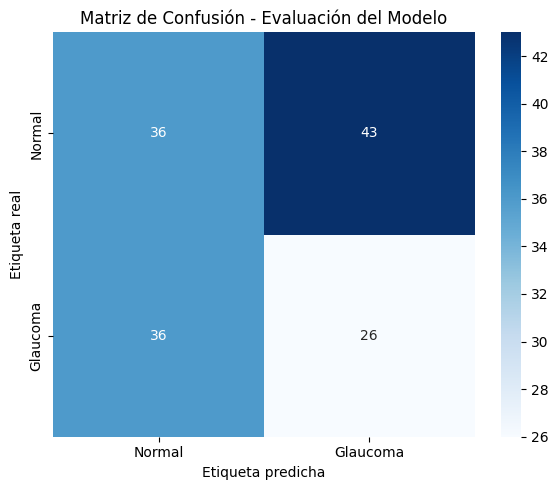


              precision    recall  f1-score   support

      Normal       0.50      0.46      0.48        79
    Glaucoma       0.38      0.42      0.40        62

    accuracy                           0.44       141
   macro avg       0.44      0.44      0.44       141
weighted avg       0.45      0.44      0.44       141



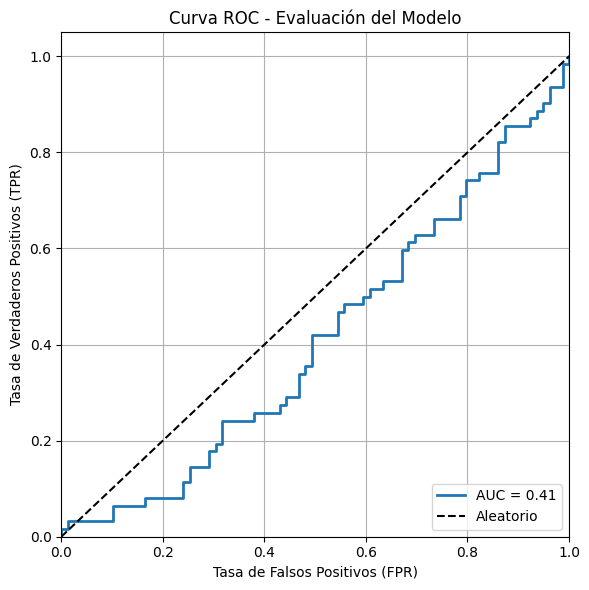


Área bajo la curva ROC (AUC): 0.4108


In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Obtener las clases reales y las predicciones del modelo
y_true = test_generator.classes
y_probs = model.predict(test_generator, verbose=0).flatten()
y_pred = (y_probs > 0.5).astype(int)

# 1. Matriz de confusión con Seaborn
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal", "Glaucoma"], 
            yticklabels=["Normal", "Glaucoma"])
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - Evaluación del Modelo")
plt.tight_layout()
plt.show()

# 2. Reporte de clasificación
print("\n" + classification_report(y_true, y_pred, target_names=["Normal", "Glaucoma"]))

# 3. Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Evaluación del Modelo")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. AUC explícito
print(f"\nÁrea bajo la curva ROC (AUC): {roc_auc_score(y_true, y_probs):.4f}")


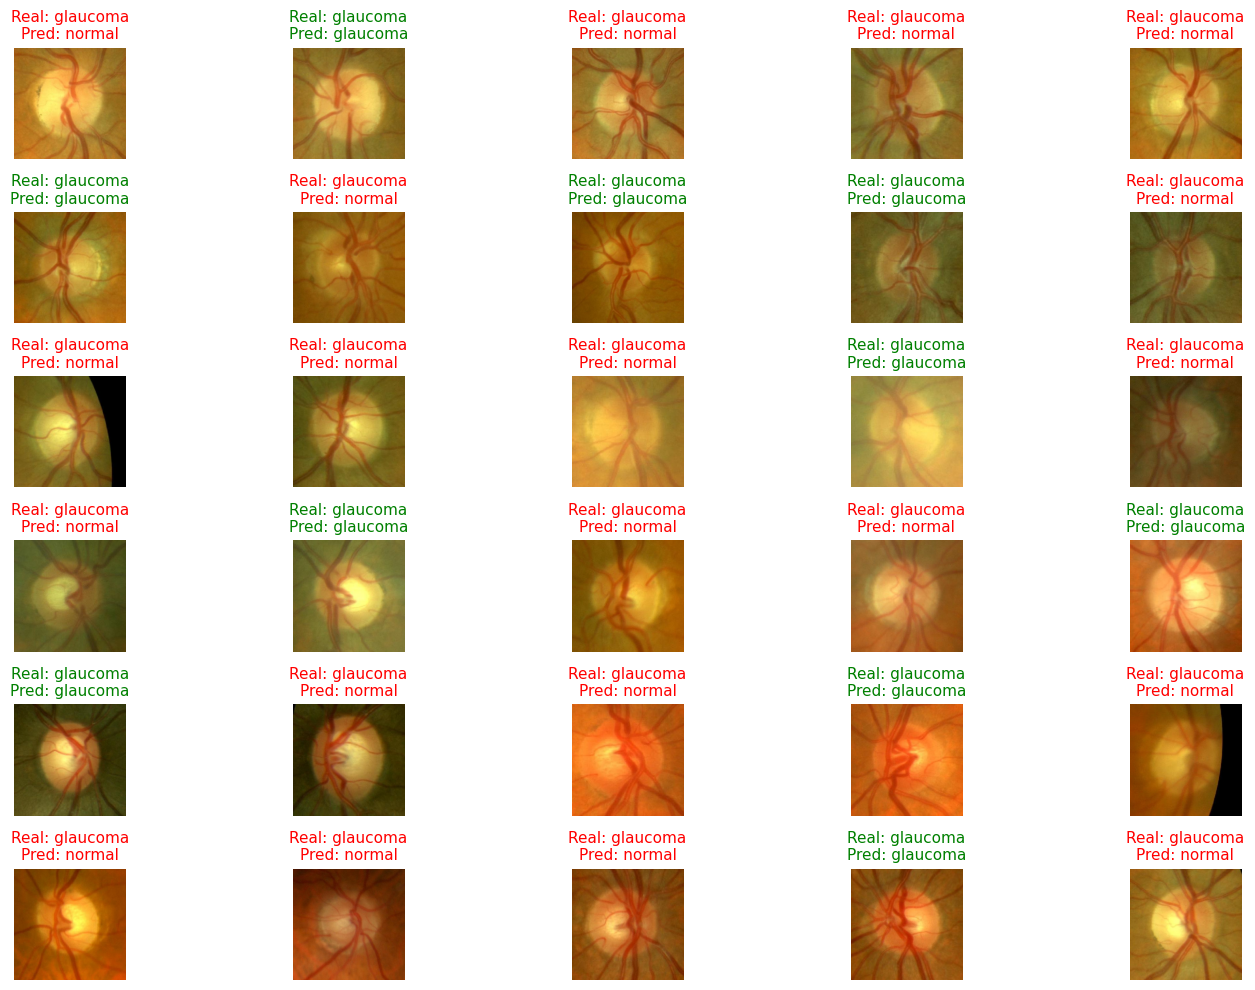

In [13]:
def display_predictions_from_generator(model, generator, class_names=None, num_images=30):
    # Obtener un batch del generador (asegúrate de que shuffle=False)
    images, labels = next(generator)

    # Hacer predicciones
    preds_probs = model.predict(images, verbose=0)
    preds_binary = (preds_probs > 0.5).astype(int).flatten()

    # Obtener nombres de clase del generador si no se han proporcionado
    if class_names is None:
        class_names = list(generator.class_indices.keys())

    # Convertir imágenes para visualización si están preprocesadas
    images_vis = images.copy()
    if images_vis.min() < 0:  # Imagen preprocesada tipo VGG16 (valores negativos)
        images_vis = np.clip(images_vis + [103.939, 116.779, 123.68], 0, 255)
        images_vis = images_vis[..., ::-1]  # BGR → RGB
    images_vis = np.clip(images_vis, 0, 255).astype("uint8")

    # Mostrar imágenes con predicción
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images_vis))):
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(preds_binary[i])]
        title_color = "green" if true_label == pred_label else "red"

        plt.subplot(6, 5, i + 1)
        plt.imshow(images_vis[i])
        plt.title(f"Real: {true_label}\nPred: {pred_label}", color=title_color, fontsize=11)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 8. Llamar a la función para ver resultados visuales
display_predictions_from_generator(model, test_generator, class_names=["normal", "glaucoma"])

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score
)
from tensorflow.keras.models import load_model

def evaluate_model_performance(model, generator, class_names=["Normal", "Glaucoma"]):
    # Obtener etiquetas verdaderas y probabilidades
    y_true = generator.classes
    y_probs = model.predict(generator, verbose=0).flatten()

    # Calcular FPR, TPR, AUC y mejor umbral (Youden)
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    youden_index = tpr - fpr
    best_index = np.argmax(youden_index)
    best_threshold = thresholds[best_index]
    y_pred = (y_probs > best_threshold).astype(int)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Etiqueta predicha")
    plt.ylabel("Etiqueta real")
    plt.title("Matriz de Confusión - Evaluación del Modelo")
    plt.tight_layout()
    plt.show()

    # Métricas manuales
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    specificity = tn / (tn + fp) if (tn + fp) else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print("\n--- Métricas Manuales con Umbral Óptimo ---")
    print(f"Umbral óptimo (Youden): {best_threshold:.2f}")
    print(f"Normal clasificado como normal (TN): {tn}")
    print(f"Normal clasificado como glaucoma (FP): {fp}")
    print(f"Glaucoma clasificado como normal (FN): {fn}")
    print(f"Glaucoma clasificado como glaucoma (TP): {tp}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precisión (PPV): {precision:.2f}")
    print(f"Sensibilidad (TPR): {recall:.2f}")
    print(f"Especificidad (TNR): {specificity:.2f}")

    # Classification report
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Curva ROC con punto óptimo
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
    plt.plot(fpr[best_index], tpr[best_index], 'ro', label=f"Umbral óptimo = {best_threshold:.2f}")
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title("Curva ROC - Evaluación del Modelo")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nÁrea bajo la curva ROC (AUC): {roc_auc:.4f}")


In [231]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Cargar VGG16 preentrenada en ImageNet, sin las capas densas finales
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# 2. Congelar TODAS las capas del modelo base (no se entrenan)
for layer in base_model.layers:
    layer.trainable = False

# 3. Añadir tu propio clasificador encima
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)  # Regularización opcional
predictions = Dense(1, activation='sigmoid')(x)  # Clasificación binaria

# 4. Construir el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compilar el modelo (solo entrenarás la capa final)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Este modelo ahora entrena solo la capa densa, evaluando el rendimiento de VGG16 tal cual está
model.summary()

Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [68]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

# Callback personalizado para guardar precisión por batch
class BatchAccuracyCallback(Callback):
    def __init__(self):
        self.batch_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        if logs is not None:
            self.batch_accuracies.append(logs.get('accuracy'))
    
# Callback personalizado para registrar precisión en test por época
class TestAccuracyCallback(Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_data, verbose=0)
        self.test_accuracies.append(acc)

# Crear instancia con tu test_generator
test_acc_callback = TestAccuracyCallback(test_generator)


# Instancia del callback personalizado
batch_acc_callback = BatchAccuracyCallback()

# Lista de callbacks combinados
callbacks = [
    ModelCheckpoint(
        filepath="./checkpoints/best_model.keras",  # Guardar el modelo completo
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=10,  # Puedes ajustar
        restore_best_weights=True,
        verbose=1
    ),
    test_acc_callback,
    batch_acc_callback
]

In [69]:
# Entrenamiento con todos los callbacks
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    callbacks=callbacks,
)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.4955 - loss: 2.2878
Epoch 1: val_loss improved from inf to 1.03757, saving model to ./checkpoints/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 598ms/step - accuracy: 0.4985 - loss: 2.2657 - val_accuracy: 0.6950 - val_loss: 1.0376
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7294 - loss: 0.8775
Epoch 2: val_loss improved from 1.03757 to 0.54696, saving model to ./checkpoints/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step - accuracy: 0.7307 - loss: 0.8702 - val_accuracy: 0.8085 - val_loss: 0.5470
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8236 - loss: 0.6106
Epoch 3: val_loss improved from 0.54696 to 0.49489, saving model to ./checkpoints/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 591ms/step - accuracy: 0.8241 - loss: 0.6077 - val_accuracy: 0.8511 - val_loss: 0.4949
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8792 - loss: 0.4055
Epoch 4: val_

In [99]:
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"Pérdida (loss): {loss:.4f}")
print(f"Precisión (accuracy): {acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.8686 - loss: 0.3441
Pérdida (loss): 0.2554
Precisión (accuracy): 0.9078


In [8]:
import matplotlib.pyplot as plt

# Suponiendo que guardaste el historial así:
# history = model.fit(...)

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Precisión entrenamiento')
    if val_acc: plt.plot(epochs, val_acc, label='Precisión validación')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Pérdida entrenamiento')
    if val_loss: plt.plot(epochs, val_loss, label='Pérdida validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Llamar:
plot_training_history(history)

NameError: name 'history' is not defined

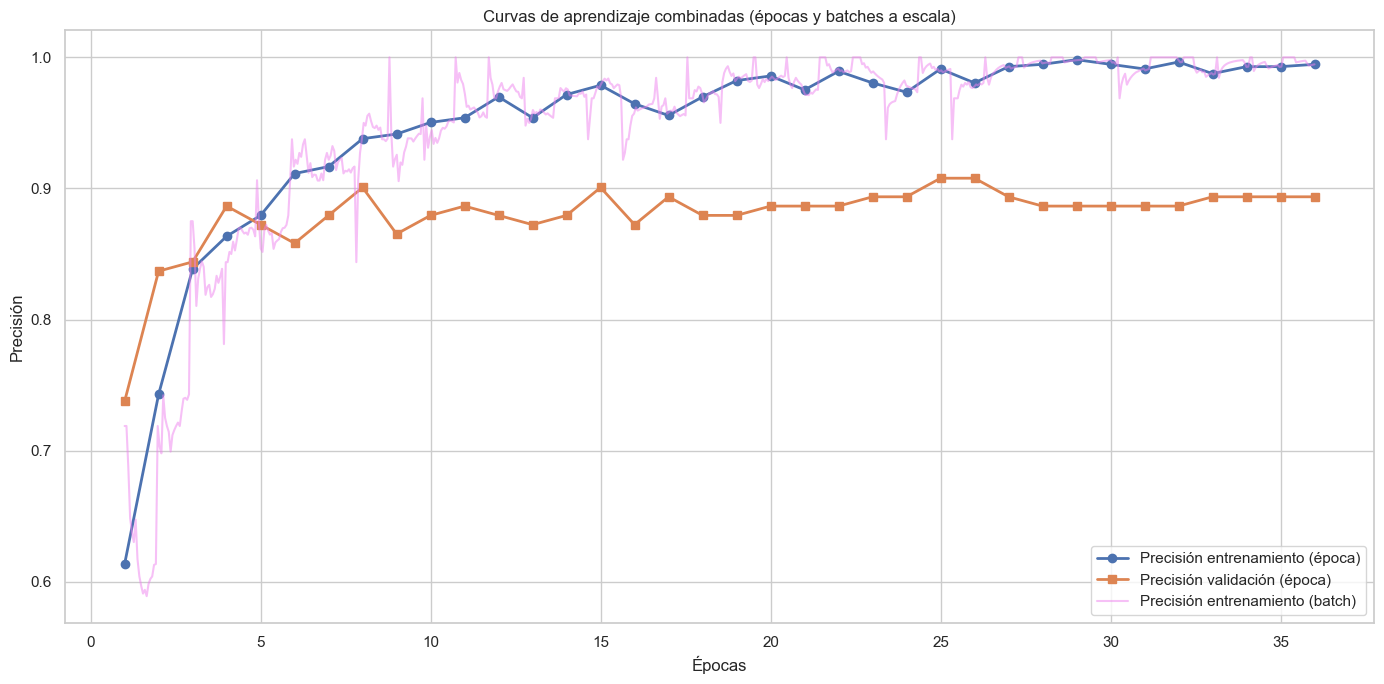

In [109]:
import matplotlib.pyplot as plt
import numpy as np

def plot_full_learning_dynamics_scaled(history, test_acc_callback, batch_acc_callback):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    test_acc = test_acc_callback.test_accuracies
    batch_acc = batch_acc_callback.batch_accuracies

    n_epochs = len(acc)
    n_batches = len(batch_acc)

    # Ejes temporales
    epochs = np.arange(1, n_epochs + 1)
    batch_x_scaled = np.linspace(1, n_epochs, n_batches)  # Escalado en tiempo de entrenamiento

    fig, ax = plt.subplots(figsize=(14, 7))

    # Precisión por época
    ax.plot(epochs, acc, label='Precisión entrenamiento (época)', marker='o', linewidth=2)
    if val_acc:
        ax.plot(epochs, val_acc, label='Precisión validación (época)', marker='s', linewidth=2)

    # Precisión por batch reescalada
    ax.plot(batch_x_scaled, batch_acc, label='Precisión entrenamiento (batch)', color='violet', alpha=0.5)

    # Estética
    ax.set_xlabel("Épocas")
    ax.set_ylabel("Precisión")
    ax.set_title("Curvas de aprendizaje combinadas (épocas y batches a escala)")
    ax.grid(True)
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plot_full_learning_dynamics_scaled(history, test_acc_callback, batch_acc_callback)

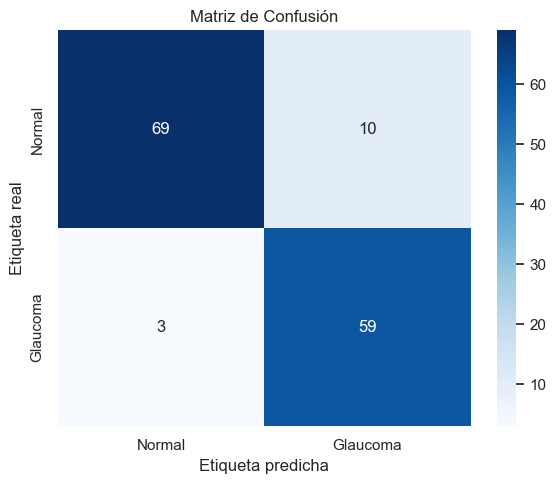


              precision    recall  f1-score   support

      Normal       0.96      0.87      0.91        79
    Glaucoma       0.86      0.95      0.90        62

    accuracy                           0.91       141
   macro avg       0.91      0.91      0.91       141
weighted avg       0.91      0.91      0.91       141



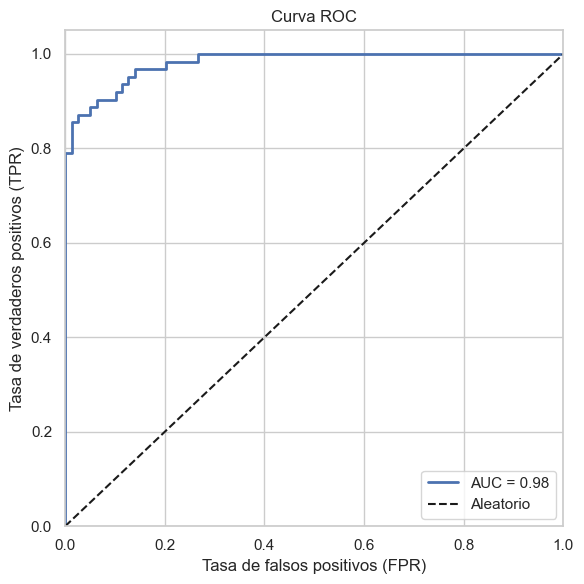


Área bajo la curva ROC (AUC): 0.9816


In [110]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Obtener predicciones (probabilidades y clases)
y_true = test_generator.classes
y_probs = model.predict(test_generator, verbose=0).flatten()
y_pred = (y_probs > 0.5).astype(int)

# 1. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Glaucoma"], yticklabels=["Normal", "Glaucoma"])
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

# 2. Reporte de clasificación
print("\n" + classification_report(y_true, y_pred, target_names=["Normal", "Glaucoma"]))

# 3. Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. AUC explícito
print(f"\nÁrea bajo la curva ROC (AUC): {roc_auc_score(y_true, y_probs):.4f}")


In [111]:
from scipy.stats import ttest_rel

# Suponiendo que tienes estos arrays:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']

# t-test apareado
t_stat, p_val = ttest_rel(acc_train, acc_val)
print(f"t = {t_stat:.4f}, p = {p_val:.4f}")

if p_val < 0.05:
    print("Diferencia significativa entre precisión de entrenamiento y validación → posible sobreajuste.")
else:
    print("No hay evidencia estadística de sobreajuste.")


t = 7.5110, p = 0.0000
Diferencia significativa entre precisión de entrenamiento y validación → posible sobreajuste.


In [112]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(acc_train, acc_val)
print(f"Wilcoxon p = {p:.4f}")

Wilcoxon p = 0.0000


In [113]:
import numpy as np
from scipy.stats import ttest_1samp

gap = np.array(acc_train) - np.array(acc_val)

# Test de una muestra contra media 0 (sin diferencia)
t_stat, p_val = ttest_1samp(gap, 0)
print(f"Media del gap: {gap.mean():.4f}")
print(f"t = {t_stat:.4f}, p = {p_val:.4f}")

if p_val < 0.05 and gap.mean() > 0:
    print("Gap de generalización estadísticamente significativo → sobreajuste.")

Media del gap: 0.0678
t = 7.5110, p = 0.0000
Gap de generalización estadísticamente significativo → sobreajuste.


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def display_predictions_from_generator(model, generator, class_names=["normal", "glaucoma"], num_images=30):
    # Obtener un batch del generador (asegúrate de que shuffle=False al crearlo)
    images, labels = next(generator)

    # Hacer predicciones
    preds_probs = model.predict(images, verbose=0)
    preds_binary = (preds_probs > 0.5).astype(int).flatten()

    # Escalar imágenes si están entre 0-1 (para visualizar bien)
    images = (images * 255).astype("uint8") if images.max() <= 1 else images.astype("uint8")

    # Mostrar imágenes
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(preds_binary[i])]
        title_color = "green" if true_label == pred_label else "red"

        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Real: {true_label}\nPred: {pred_label}", color=title_color, fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_predictions_from_generator(best_model, test_generator, class_names=["normal", "glaucoma"])


NameError: name 'best_model' is not defined

# **USAMOS LA BASE PREENTRENADA COGENLANDO LAS CAPAS**

Se está congelando todas las capas convolucionales, es decir, estas no se entrenan, puea solo extraen características, permitiendo ahorrar tiempo de entrenamiento y evitando el sobreajuste si se tienen pocos datos

In [331]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.applications import VGG16

# Entrada
inputs = Input(shape=(224, 224, 3))

# Base VGG16
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

# Congelar capas
for layer in base_model.layers:
    layer.trainable = False

# Cabeza personalizada
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Modelo final
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 18,030,593 (68.78 MB)

 Trainable params: 3,265,729 (12.46 MB)

 Non-trainable params: 14,764,864 (56.32 MB)

In [328]:
import os
os.makedirs("checkpoints", exist_ok=True)

In [332]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

# Callback personalizado para guardar precisión por batch
class BatchAccuracyCallback(Callback):
    def __init__(self):
        self.batch_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        if logs is not None:
            self.batch_accuracies.append(logs.get('accuracy'))
    
# Callback personalizado para registrar precisión en test por época
class TestAccuracyCallback(Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_data, verbose=0)
        self.test_accuracies.append(acc)

# Crear instancia con tu test_generator
test_acc_callback = TestAccuracyCallback(test_generator)


# Instancia del callback personalizado
batch_acc_callback = BatchAccuracyCallback()

# Lista de callbacks combinados
callbacks = [
    ModelCheckpoint(
        filepath="./checkpoints/best_model.keras",  # Guardar el modelo completo
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=15,  # Puedes ajustar a 50 si lo deseas, pero 10 suele ser más práctico
        restore_best_weights=True,
        verbose=1
    ),
    test_acc_callback,
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=5,
        factor=0.5,
        verbose=1
    ),
    batch_acc_callback
]

In [333]:
# Entrenamiento con todos los callbacks
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=callbacks,
)
model.save

/opt/anaconda3/envs/keras_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.5418 - loss: 1.3170
Epoch 1: val_loss improved from inf to 0.88878, saving model to ./checkpoints/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 699ms/step - accuracy: 0.5471 - loss: 1.3030 - val_accuracy: 0.7801 - val_loss: 0.8888 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8229 - loss: 0.5006
Epoch 2: val_loss improved from 0.88878 to 0.76004, saving model to ./checkpoints/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 599ms/step - accuracy: 0.8227 - loss: 0.5004 - val_accuracy: 0.8085 - val_loss: 0.7600 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8736 - loss: 0.4347
Epoch 3: val_loss improved from 0.76004 to 0.64197, saving model to ./checkpoints/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 592ms/step - accuracy: 0.8742 - loss: 0.4315 - val_accuracy: 0.8440 - val_loss: 0.6420 - learning_rate: 1.0000e-04
Epoch 4/30


<bound method Model.save of <Functional name=functional_94, built=True>>

In [250]:
# Ver la precisión por batch (por ejemplo, los primeros 10)
print(batch_acc_callback.batch_accuracies[:50])

[0.53125, 0.53125, 0.5104166865348816, 0.4913793206214905, 0.5, 0.5, 0.49528300762176514, 0.49180328845977783, 0.4855072498321533, 0.48376622796058655, 0.4794117510318756, 0.4838709533214569, 0.5, 0.4954128563404083, 0.5, 0.5, 0.5075187683105469, 0.5141844153404236, 0.5625, 0.546875, 0.5416666865348816, 0.5703125, 0.59375, 0.5885416865348816, 0.5982142686843872, 0.58984375, 0.5729166865348816, 0.5843750238418579, 0.5909090638160706, 0.6015625, 0.6014851331710815, 0.5940366983413696, 0.5897436141967773, 0.5979999899864197, 0.597744345664978, 0.5992907881736755, 0.71875, 0.703125, 0.6458333134651184, 0.625, 0.637499988079071, 0.6666666865348816, 0.6830357313156128, 0.6640625, 0.6493055820465088, 0.643750011920929, 0.65625, 0.6559139490127563, 0.6608911156654358, 0.646789014339447]


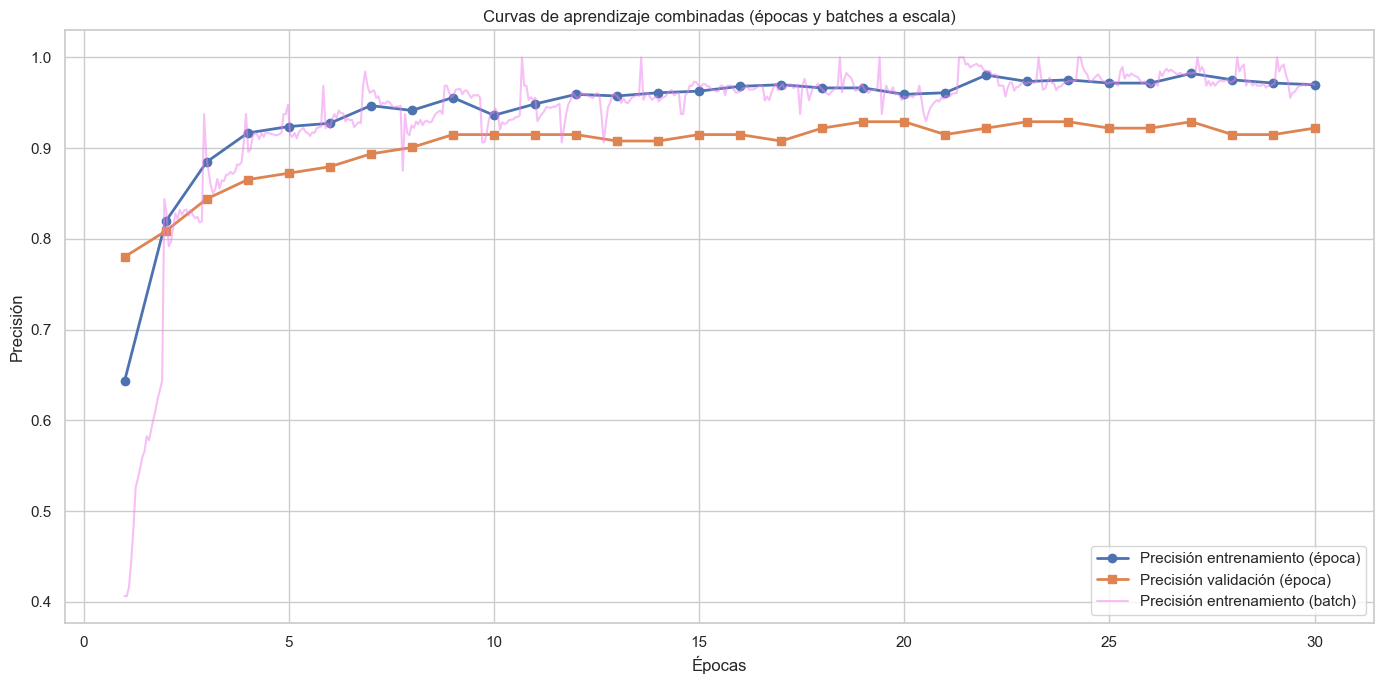

In [334]:
import matplotlib.pyplot as plt
import numpy as np

def plot_full_learning_dynamics_scaled(history, test_acc_callback, batch_acc_callback):
    # Extraer datos reales del entrenamiento
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    test_acc = test_acc_callback.test_accuracies
    batch_acc = batch_acc_callback.batch_accuracies

    # Número de épocas y batches
    n_epochs = len(acc)
    n_batches = len(batch_acc)

    # Ejes temporales
    epochs = np.arange(1, n_epochs + 1)
    batch_x_scaled = np.linspace(1, n_epochs, n_batches)

    # Crear gráfico
    fig, ax = plt.subplots(figsize=(14, 7))

    # === Precisión por época ===
    ax.plot(epochs, acc, label='Precisión entrenamiento (época)', marker='o', linewidth=2)
    if val_acc:
        ax.plot(epochs, val_acc, label='Precisión validación (época)', marker='s', linewidth=2)

    # === Precisión por batch reescalada ===
    ax.plot(batch_x_scaled, batch_acc, label='Precisión entrenamiento (batch)', color='violet', alpha=0.5)

    # Estética
    ax.set_xlabel("Épocas")
    ax.set_ylabel("Precisión")
    ax.set_title("Curvas de aprendizaje combinadas (épocas y batches a escala)")
    ax.grid(True)
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plot_full_learning_dynamics_scaled(history, test_acc_callback, batch_acc_callback)

In [335]:
loss, accuracy = model.evaluate(test_generator)
print(f"Precisión en test: {accuracy:.2%}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.8870 - loss: 0.2429
Precisión en test: 91.49%


In [336]:
from scipy.stats import ttest_rel, ttest_1samp
import numpy as np

def test_overfitting_pvalues(history):
    acc_train = np.array(history.history['accuracy'])
    acc_val = np.array(history.history['val_accuracy'])

    # 1. T-test apareado entre precisión de entrenamiento y validación
    t_stat_1, p_val_1 = ttest_rel(acc_train, acc_val)

    # 2. Gap de generalización por época
    gap = acc_train - acc_val
    t_stat_2, p_val_2 = ttest_1samp(gap, 0)  # test de una muestra: ¿media del gap > 0?

    print("=== Pruebas estadísticas de sobreajuste ===")
    print(f"T-test entre curvas de precisión:")
    print(f"  t = {t_stat_1:.4f}, p = {p_val_1:.4f}")
    if p_val_1 < 0.05:
        print("Diferencia significativa → posible sobreajuste.")
    else:
        print("No hay evidencia estadística de sobreajuste entre curvas.")

    print(f"\nT-test del gap de generalización:")
    print(f"  Media del gap = {gap.mean():.4f}")
    print(f"  t = {t_stat_2:.4f}, p = {p_val_2:.4f}")
    if p_val_2 < 0.05 and gap.mean() > 0:
        print("Gap positivo y significativo → sobreajuste probable.")
    else:
        print("Gap no significativo o negativo → no se detecta sobreajuste.")

test_overfitting_pvalues(history)

=== Pruebas estadísticas de sobreajuste ===
T-test entre curvas de precisión:
  t = 6.2004, p = 0.0000
Diferencia significativa → posible sobreajuste.

T-test del gap de generalización:
  Media del gap = 0.0397
  t = 6.2004, p = 0.0000
Gap positivo y significativo → sobreajuste probable.


In [337]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Cargar el mejor modelo
best_model = load_model('./checkpoints/best_model.keras')

# Función corregida
def plot_confusion_matrix(model, generator, class_names=["normal", "glaucoma"], threshold=0.5):
    y_true = generator.classes
    y_pred_probs = model.predict(generator, verbose=0)
    y_pred = (y_pred_probs > threshold).astype(int).flatten()

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Visualización
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusión")
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.tight_layout()
    plt.show(block=True)  # Forzado para scripts

    # Métricas adicionales
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    specificity = tn / (tn + fp) if (tn + fp) else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print(f"Normal clasificado como normal (TN): {tn}")
    print(f"Normal clasificado como glaucoma (FP): {fp}")
    print(f"Glaucoma clasificado como normal (FN): {fn}")
    print(f"Glaucoma clasificado como glaucoma (TP): {tp}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precisión (PPV): {precision:.2f}")
    print(f"Sensibilidad (TPR): {recall:.2f}")
    print(f"Especificidad (TNR): {specificity:.2f}")

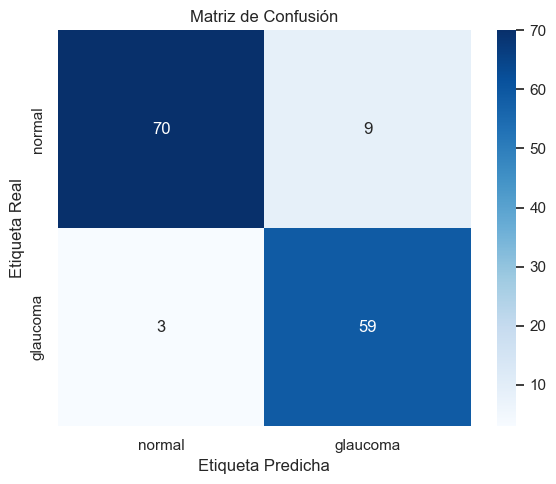

Normal clasificado como normal (TN): 70
Normal clasificado como glaucoma (FP): 9
Glaucoma clasificado como normal (FN): 3
Glaucoma clasificado como glaucoma (TP): 59
Accuracy: 0.91
Precisión (PPV): 0.87
Sensibilidad (TPR): 0.95
Especificidad (TNR): 0.89


In [338]:
plot_confusion_matrix(best_model, test_generator)

In [339]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_roc_metrics(model, generator):
    # Predicciones verdaderas y probabilidades predichas
    y_true = generator.classes
    y_pred_probs = model.predict(generator, verbose=0).flatten()
    
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Índice de Youden
    j_scores = tpr - fpr
    j_best_idx = np.argmax(j_scores)
    best_threshold = thresholds[j_best_idx]

    return fpr, tpr, thresholds, roc_auc, best_threshold, y_true, y_pred_probs

def plot_roc_curve(fpr, tpr, roc_auc, best_threshold, thresholds):
    # Umbral óptimo (Youden)
    j_scores = tpr - fpr
    j_best_idx = np.argmax(j_scores)
    best_fpr, best_tpr = fpr[j_best_idx], tpr[j_best_idx]

    # Gráfica ROC
    sns.set(style="whitegrid")
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='#2a9d8f', lw=2.5, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.5, label='Azar (AUC = 0.50)')
    plt.scatter(best_fpr, best_tpr, color='#e76f51', s=80, edgecolors='black', zorder=5,
                label=f'Umbral óptimo = {best_threshold:.2f}')
    plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
    plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
    plt.title('Curva ROC', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

AUC-ROC: 0.9894
Umbral óptimo (Youden): 0.93


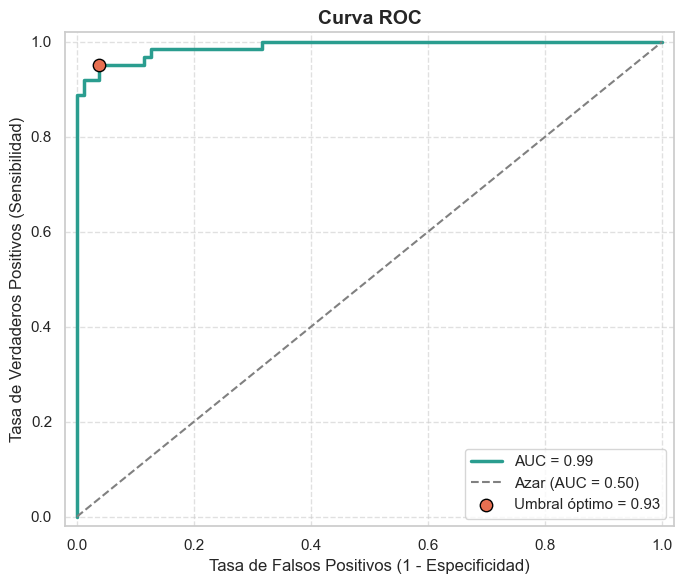

In [340]:
# Calcular métricas y mostrar resultados coherentes
fpr, tpr, thresholds, auc_acrima, best_thresh_acrima, y_true_acrima, y_pred_acrima = get_roc_metrics(model, test_generator)

# Imprimir valores
print(f"AUC-ROC: {auc_acrima:.4f}")
print(f"Umbral óptimo (Youden): {best_thresh_acrima:.2f}")

# Graficar
plot_roc_curve(fpr, tpr, auc_acrima, best_thresh_acrima, thresholds)


In [176]:
# Generar predicciones manualmente y verificar consistencia
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=0).flatten()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Calcular el mejor umbral (Youden J)
j_scores = tpr - fpr
j_best_idx = np.argmax(j_scores)
best_thresh = thresholds[j_best_idx]

print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Umbral óptimo (Youden): {best_thresh:.2f}")

AUC-ROC: 0.9792
Umbral óptimo (Youden): 0.95


In [350]:
import matplotlib.pyplot as plt
import numpy as np

def display_predictions_from_generator(model, generator, class_names=["normal", "glaucoma"], num_images=30):
    # Obtener un batch del generador (asegúrate de que shuffle=False al crearlo)
    images, labels = next(generator)

    # Hacer predicciones
    preds_probs = model.predict(images, verbose=0)
    preds_binary = (preds_probs > 0.5).astype(int).flatten()

    # Copiar imágenes para visualización
    images_vis = images.copy()

    # Si las imágenes están preprocesadas tipo VGG16 (valores negativos, en BGR), deshacer preprocesamiento
    if images_vis.min() < 0:  # Indicador de preprocesado VGG16
        images_vis += [103.939, 116.779, 123.68]  # Revertir sustracción de medias
        images_vis = images_vis[..., ::-1]        # Convertir de BGR a RGB

    # Asegurar que los valores están en el rango [0, 255] y en uint8 para mostrar bien
    images_vis = np.clip(images_vis, 0, 255).astype("uint8")

    # Mostrar imágenes con predicciones
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images_vis))):
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(preds_binary[i])]
        title_color = "green" if true_label == pred_label else "red"

        plt.subplot(6, 5, i + 1)
        plt.imshow(images_vis[i])
        plt.title(f"Real: {true_label}\nPred: {pred_label}", color=title_color, fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


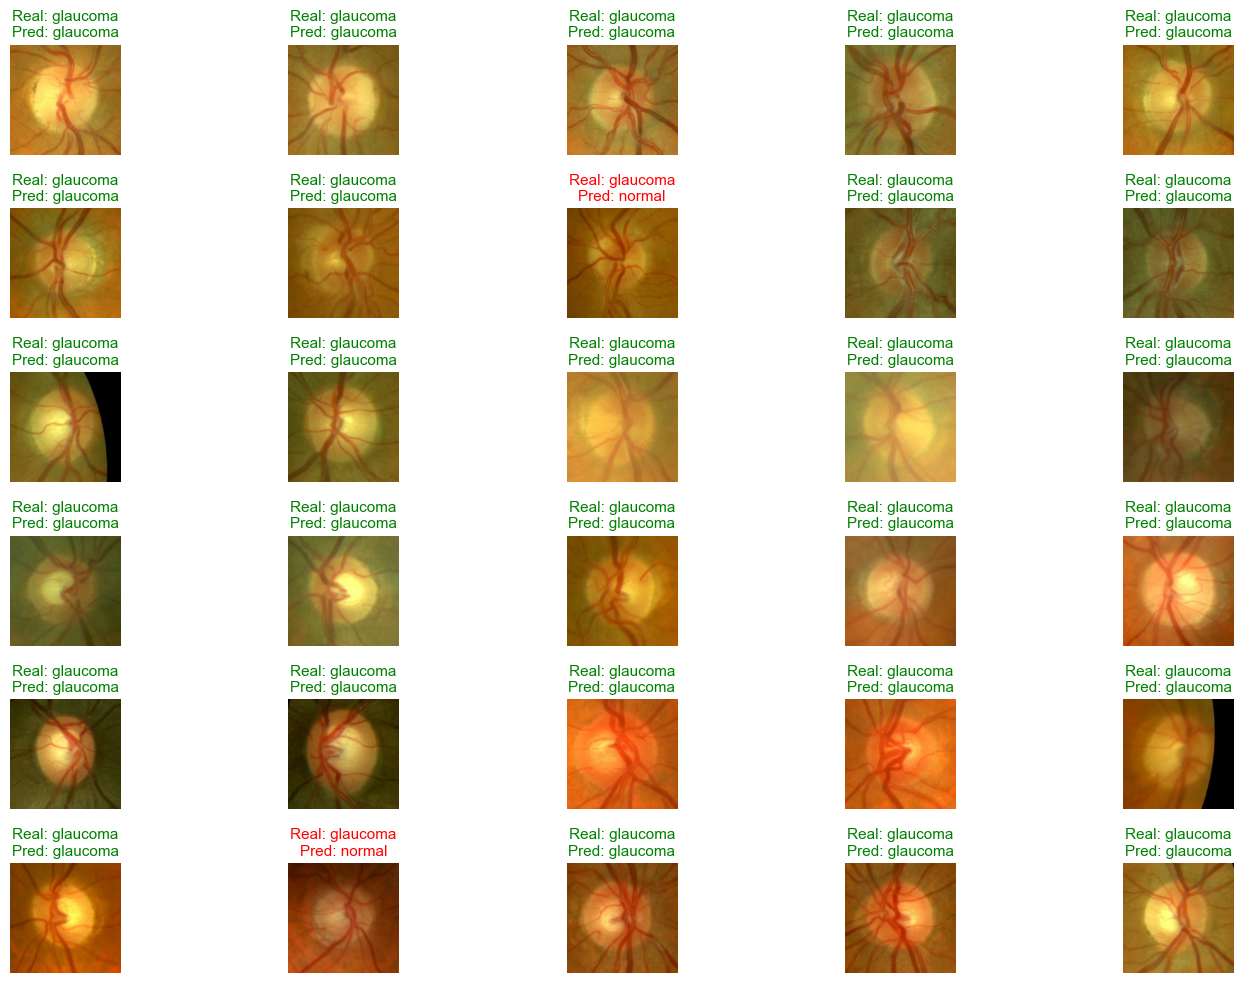

In [366]:
display_predictions_from_generator(best_model, test_generator, class_names=["normal", "glaucoma"])

# RENDIMIENTO CON WEB EXTERNA

In [346]:
import os

# Rutas originales dentro de mi ordenador
base_path = '/Users/alvarogonzalez/Downloads/Dataset-4 MIAG 2-2'
normal_path = os.path.join(base_path, 'Normal')
glaucoma_path = os.path.join(base_path, 'Glaucoma')

# Función para listar imágenes .jpg en una carpeta
def listar_jpgs(directorio):
    return sorted([
        f for f in os.listdir(directorio)
        if f.lower().endswith('.jpg') and os.path.isfile(os.path.join(directorio, f))
    ])

# Listado de archivos que sean válidos
jpgs_normal = listar_jpgs(normal_path)
jpgs_glaucoma = listar_jpgs(glaucoma_path)

# Resultados
print(f"Imágenes .jpg en 'Normal': {len(jpgs_normal)}")
print(f"Imágenes .jpg en 'Glaucoma': {len(jpgs_glaucoma)}")

# Ejemplos de las imágenes para contrastar que se haya redireccionado bien la ruta:
print("\nEjemplos de archivos:")
print("Normal:", jpgs_normal[:5])
print("Glaucoma:", jpgs_glaucoma[:5])

Imágenes .jpg en 'Normal': 255
Imágenes .jpg en 'Glaucoma': 200

Ejemplos de archivos:
Normal: ['Im001.jpg', 'Im002.jpg', 'Im003.jpg', 'Im004.jpg', 'Im005.jpg']
Glaucoma: ['Im256.jpg', 'Im257.jpg', 'Im258.jpg', 'Im259.jpg', 'Im260.jpg']


In [347]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

rimone_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

rimone_generator = rimone_datagen.flow_from_directory(
    directory='/Users/alvarogonzalez/Downloads/RIMONE-db-r2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print("Clases detectadas:", rimone_generator.class_indices)

Found 455 images belonging to 2 classes.
Clases detectadas: {'Glaucoma': 0, 'Normal': 1}


In [256]:
print(rimone_generator.class_indices)
print(rimone_generator.classes[:800])

{'Glaucoma': 0, 'Normal': 1}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [348]:
from tensorflow.keras.models import load_model

# Cargar el mejor modelo guardado automáticamente por ModelCheckpoint
model = load_model("./checkpoints/best_model.keras")

# Evaluar en el conjunto RIM-ONE-r2
loss, accuracy = model.evaluate(rimone_generator, verbose=1)
print(f"Precisión en RIM-ONE-r2: {accuracy * 100:.2f}%")

/opt/anaconda3/envs/keras_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 385ms/step - accuracy: 0.6413 - loss: 2.2895
Precisión en RIM-ONE-r2: 53.41%


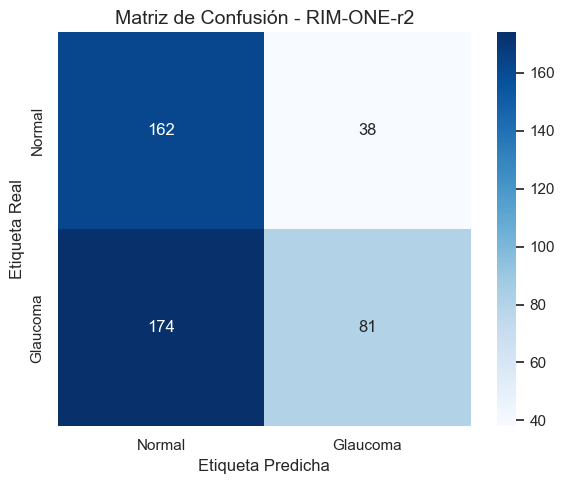

Normal clasificado como normal (TN): 162
Normal clasificado como glaucoma (FP): 38
Glaucoma clasificado como normal (FN): 174
Glaucoma clasificado como glaucoma (TP): 81

Accuracy: 0.53
Precisión (PPV): 0.68
Sensibilidad (TPR / Recall): 0.32
Especificidad (TNR): 0.81


In [349]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Cargar el mejor modelo guardado (opcional, si no lo tienes cargado ya)
model = load_model('./checkpoints/best_model.keras')

def plot_confusion_matrix(model, generator, class_names=None, threshold=0.5):
    """
    Genera y muestra la matriz de confusión con métricas adicionales.

    Parameters:
    - model: modelo entrenado de Keras
    - generator: generador de datos (con generator.classes disponible)
    - class_names: lista de etiquetas de clases, por ejemplo ["Normal", "Glaucoma"]
    - threshold: umbral de clasificación binaria
    """
    # Etiquetas verdaderas y predichas
    y_true = generator.classes
    y_pred_probs = model.predict(generator, verbose=0)
    y_pred = (y_pred_probs > threshold).astype(int).flatten()

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Asegurar etiquetas si no se pasan
    if class_names is None:
        class_names = list(generator.class_indices.keys())

    # Visualización con seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusión - RIM-ONE-r2", fontsize=14)
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.tight_layout()
    plt.show(block=True)

    # Desempaquetar para métricas adicionales
    tn, fp, fn, tp = cm.ravel()

    # Métricas clave
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    specificity = tn / (tn + fp) if (tn + fp) else 0

    # Mostrar métricas
    print(f"Normal clasificado como normal (TN): {tn}")
    print(f"Normal clasificado como glaucoma (FP): {fp}")
    print(f"Glaucoma clasificado como normal (FN): {fn}")
    print(f"Glaucoma clasificado como glaucoma (TP): {tp}")
    print(f"\nAccuracy: {accuracy:.2f}")
    print(f"Precisión (PPV): {precision:.2f}")
    print(f"Sensibilidad (TPR / Recall): {recall:.2f}")
    print(f"Especificidad (TNR): {specificity:.2f}")

plot_confusion_matrix(model, rimone_generator, class_names=["Normal", "Glaucoma"])

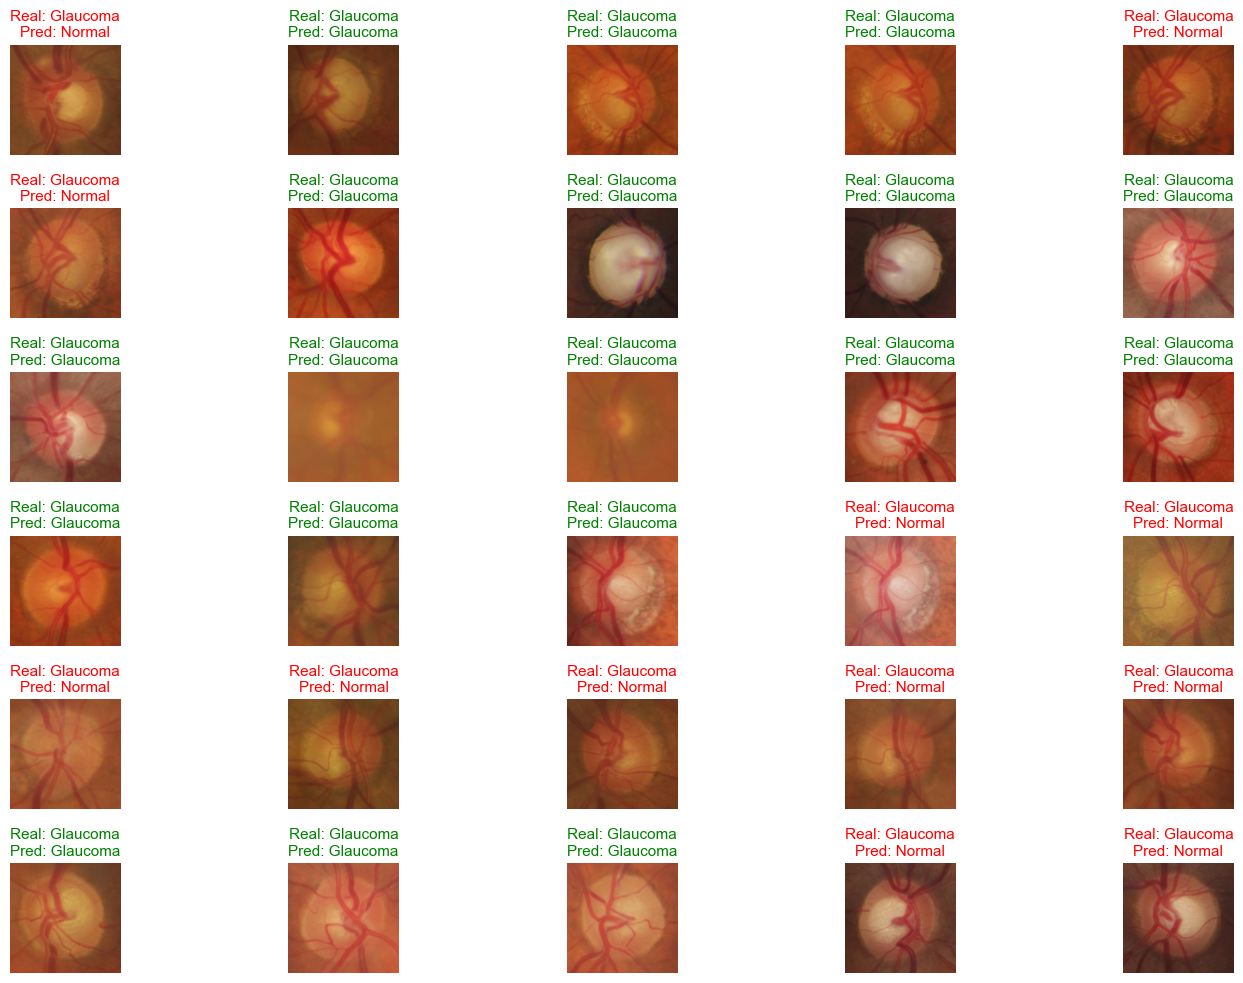

In [353]:
import matplotlib.pyplot as plt
import numpy as np

def display_predictions_from_generator(model, generator, class_names=None, num_images=30):
    # Obtener un batch del generador (asegúrate de que shuffle=False en su creación)
    images, labels = next(generator)

    # Hacer predicciones
    preds_probs = model.predict(images, verbose=0)
    preds_binary = (preds_probs > 0.5).astype(int).flatten()

    # Obtener nombres de clase del generador si no se han proporcionado
    if class_names is None:
        class_names = list(generator.class_indices.keys())

    # Convertir imágenes para visualización si están en [0, 1] o preprocesadas
    images_vis = images.copy()
    if images_vis.min() < 0:  # Imagen preprocesada tipo VGG16 (mean subtracted)
        images_vis = np.clip(images_vis + [103.939, 116.779, 123.68], 0, 255)
        images_vis = images_vis[..., ::-1]  # BGR → RGB
    images_vis = np.clip(images_vis, 0, 255).astype("uint8")

    # Mostrar imágenes
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images_vis))):
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(preds_binary[i])]
        title_color = "green" if true_label == pred_label else "red"

        plt.subplot(6, 5, i + 1)
        plt.imshow(images_vis[i])
        plt.title(f"Real: {true_label}\nPred: {pred_label}", color=title_color, fontsize=11)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_predictions_from_generator(model, rimone_generator)


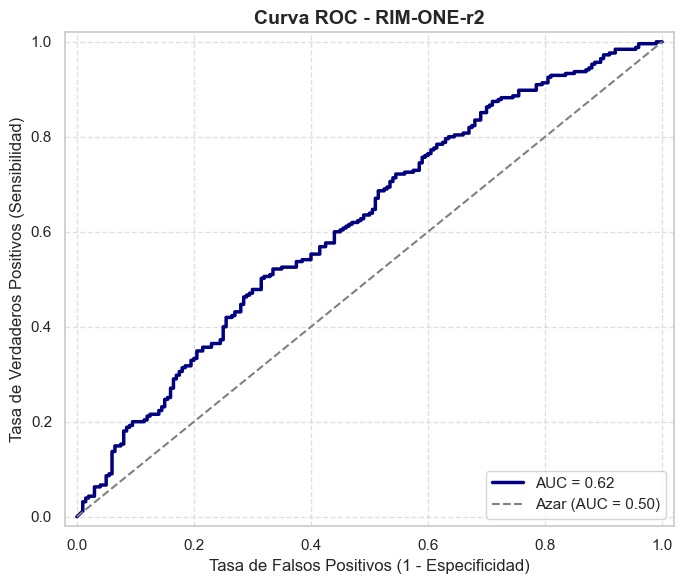

AUC-ROC RIM-ONE-r2: 0.6191
Umbral óptimo (Youden): 0.02


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Datos
y_true_rimone = rimone_generator.classes
y_pred_probs_rimone = model.predict(rimone_generator, verbose=0).flatten()

# Curva ROC
fpr_rimone, tpr_rimone, thresholds_rimone = roc_curve(y_true_rimone, y_pred_probs_rimone)
auc_rimone = auc(fpr_rimone, tpr_rimone)

# Youden J
j_scores_rimone = tpr_rimone - fpr_rimone
j_best_idx_rimone = np.argmax(j_scores_rimone)
best_thresh_rimone = thresholds_rimone[j_best_idx_rimone]
best_fpr_rimone = fpr_rimone[j_best_idx_rimone]
best_tpr_rimone = tpr_rimone[j_best_idx_rimone]

# Estilo
sns.set(style="whitegrid")

# Gráfico
plt.figure(figsize=(7, 6))
plt.plot(fpr_rimone, tpr_rimone, color='navy', lw=2.5, label=f'AUC = {auc_rimone:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.5, label='Azar (AUC = 0.50)')

# Ejes
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
plt.title('Curva ROC - RIM-ONE-r2', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Resultado
print(f"AUC-ROC RIM-ONE-r2: {auc_rimone:.4f}")
print(f"Umbral óptimo (Youden): {best_thresh_rimone:.2f}")

In [304]:
from pathlib import Path

# Todas las rutas desde el generador
loaded_files = rimone_generator.filenames
print(f"Ejemplo de imágenes cargadas: {loaded_files[:5]}")
print(f"Número total cargadas por el generador: {len(loaded_files)}")

Ejemplo de imágenes cargadas: ['Glaucoma/Im256.jpg', 'Glaucoma/Im257.jpg', 'Glaucoma/Im258.jpg', 'Glaucoma/Im259.jpg', 'Glaucoma/Im260.jpg']
Número total cargadas por el generador: 455


In [215]:
normal_dir = '/Users/alvarogonzalez/Downloads/RIMONE-db-r2/Normal'
glaucoma_dir = '/Users/alvarogonzalez/Downloads/RIMONE-db-r2/Glaucoma'

def contar_jpg_validos(path):
    return [
        f for f in os.listdir(path)
        if f.lower().endswith(('.jpg', '.jpeg')) and os.path.isfile(os.path.join(path, f))
    ]

normal_imgs = contar_jpg_validos(normal_dir)
glaucoma_imgs = contar_jpg_validos(glaucoma_dir)

print(f"Detectadas manualmente: Normal = {len(normal_imgs)}, Glaucoma = {len(glaucoma_imgs)}")


Detectadas manualmente: Normal = 255, Glaucoma = 200


In [216]:
from os.path import join

# Rutas completas esperadas
expected = [join('Normal', f) for f in normal_imgs] + [join('Glaucoma', f) for f in glaucoma_imgs]
missing = set(expected) - set(loaded_files)

print(f"Imágenes que no están siendo cargadas: {len(missing)}")
print("Ejemplos:", list(missing)[:5])

Imágenes que no están siendo cargadas: 0
Ejemplos: []


In [ ]:
print("Índices de clase en ACRIMA:", train_generator.class_indices)
print("Índices de clase en test de ACRIMA:", test_generator.class_indices)

Índices de clase en ACRIMA: {'glaucoma': 0, 'normal': 1}
Índices de clase en test de ACRIMA: {'glaucoma': 0, 'normal': 1}


In [305]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

def grad_cam(input_model, image, category_index, layer_name='block5_conv3'):
    # Paso 1: Preparar la imagen de entrada
    img_array = np.expand_dims(image, axis=0)
    img_array = preprocess_input(img_array)

    # Paso 2: Obtener el modelo de salida para la última capa convolucional
    grad_model = Model(
        inputs=[input_model.inputs],
        outputs=[input_model.get_layer(layer_name).output, input_model.output]
    )
    
    # Paso 3: Calcular las gradientes
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, category_index]  # Pérdida en la clase seleccionada

    # Paso 4: Calcular el gradiente de la clase con respecto a la salida de la capa convolucional
    grads = tape.gradient(loss, conv_output)
    
    # Paso 5: Promediar el gradiente a lo largo de todas las dimensiones de los filtros
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Paso 6: Multiplicar los pesos de los gradientes con la salida de la capa convolucional
    conv_output = conv_output[0]
    pooled_grads = np.expand_dims(pooled_grads, axis=-1)
    heatmap = np.mean(conv_output * pooled_grads, axis=-1)

    # Paso 7: Normalizar el mapa de calor
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

In [306]:
def display_gradcam(image_path, model, category_index=1):
    # Cargar y preparar la imagen
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    
    # Obtener el mapa de calor
    heatmap = grad_cam(model, img_array, category_index)

    # Visualizar la imagen y el mapa de calor
    plt.figure(figsize=(10, 10))

    # Mostrar la imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen original")
    plt.axis('off')

    # Mostrar el mapa de calor
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap, alpha=0.4, cmap='jet')  # Superponer el mapa de calor sobre la imagen
    plt.title(f"Grad-CAM (Clase {category_index})")
    plt.axis('off')

    plt.show()


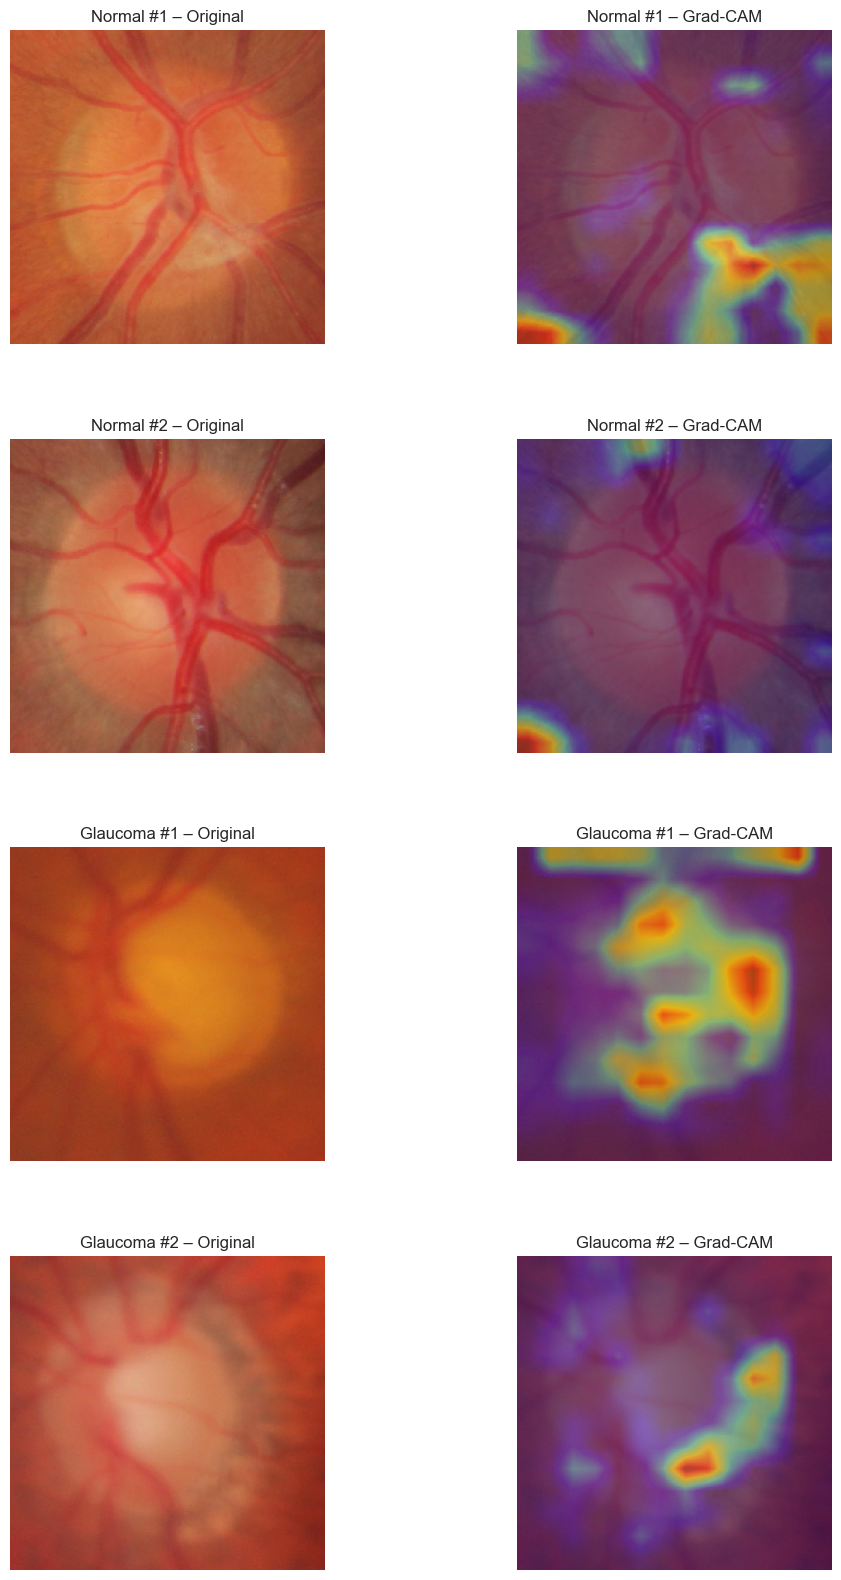

In [357]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1) Carga tu modelo entrenado
model = load_model("./checkpoints/best_model.keras")

# 2) Nombre de la última capa convolucional
last_conv_layer_name = 'block5_conv3'

# 3) Construye el modelo intermedio para Grad-CAM
grad_model = Model(
    inputs  = model.input,
    outputs = [model.get_layer(last_conv_layer_name).output,
               model.output]
)

def compute_gradcam(img_path: str, positive: bool = True, eps: float = 1e-8):
    # a) Carga la imagen y conserva una copia “raw” para mostrar
    pil_img       = image.load_img(img_path, target_size=(224,224))
    raw_img_array = image.img_to_array(pil_img).astype('uint8')

    # b) Prepara la entrada del modelo
    x = image.img_to_array(pil_img)     # float32, RGB
    x = np.expand_dims(x, axis=0)       # dim batch
    x = preprocess_input(x)             # BGR + resta medias

    # c) Forward + cálculos de gradiente
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(x)
        # preds[:,0] = P(glaucoma). Si queremos "Normal", invertimos la señal
        loss = preds[:,0] if positive else -preds[:,0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    # d) Pondera las activaciones con los gradientes
    conv_map = conv_outputs[0].numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_map[..., i] *= pooled_grads[i].numpy()

    # e) Crea y normaliza el heatmap
    heatmap = np.mean(conv_map, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + eps)

    # f) Upsample a 224×224
    heatmap = tf.image.resize(
        heatmap[..., np.newaxis],
        (224,224),
        method='bilinear'
    ).numpy().squeeze()

    return heatmap, raw_img_array

# 4) Muestrea 2 imágenes de cada clase
base_dir = '/Users/alvarogonzalez/Downloads/RIMONE-db-r2'
samples = {}
for cls_name in ['Normal', 'Glaucoma']:
    folder = os.path.join(base_dir, cls_name)
    jpgs   = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
    samples[cls_name] = random.sample(jpgs, k=2)

# 5) Dibuja todas en una sola figura con subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
plt.subplots_adjust(hspace=0.3)

row = 0
for cls_name, file_list in samples.items():
    positive = (cls_name == 'Glaucoma')
    for idx, img_file in enumerate(file_list, start=1):
        img_path = os.path.join(base_dir, cls_name, img_file)
        heatmap, raw = compute_gradcam(img_path, positive=positive)

        # Columna 0: Original
        ax0 = axes[row, 0]
        ax0.imshow(raw)
        ax0.set_title(f"{cls_name} #{idx} – Original")
        ax0.axis('off')

        # Columna 1: Grad-CAM
        ax1 = axes[row, 1]
        ax1.imshow(raw)
        ax1.imshow(heatmap, cmap='jet', alpha=0.4)
        ax1.set_title(f"{cls_name} #{idx} – Grad-CAM")
        ax1.axis('off')

        row += 1

plt.show()

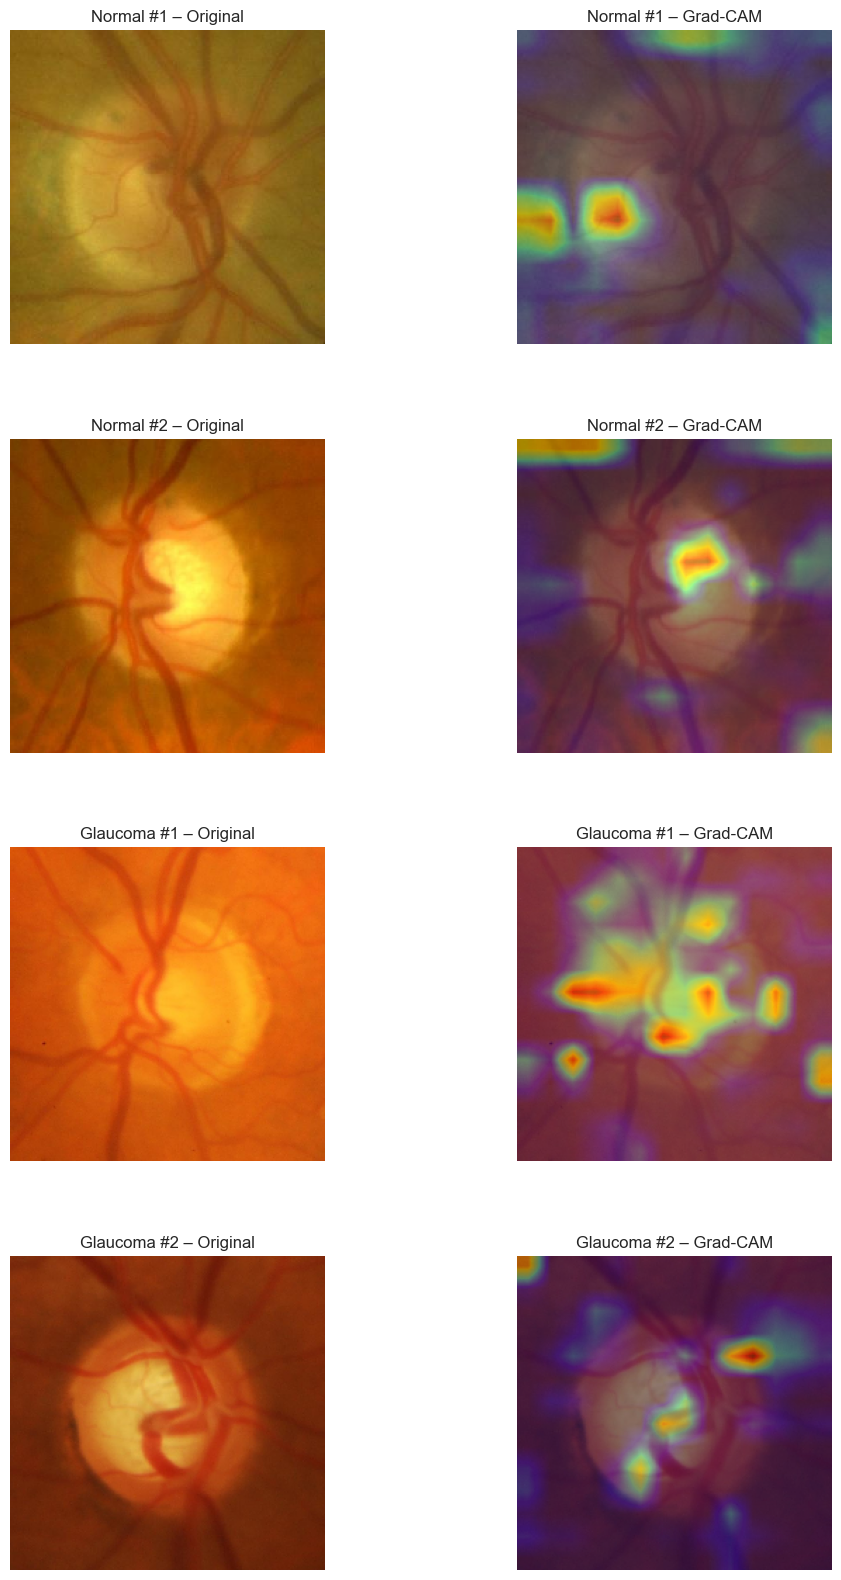

In [260]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1) Carga el modelo entrenado en ACRIMA
model = load_model("./checkpoints/best_model.keras")

# 2) Capa convolucional final usada para Grad-CAM
last_conv_layer_name = 'block5_conv3'

# 3) Modelo intermedio para capturar activaciones y salidas
grad_model = Model(
    inputs=model.input,
    outputs=[
        model.get_layer(last_conv_layer_name).output,
        model.output
    ]
)

# 4) Función de Grad-CAM
def compute_gradcam(img_path: str, positive: bool = True, eps: float = 1e-8):
    pil_img = image.load_img(img_path, target_size=(224,224))
    raw_img_array = image.img_to_array(pil_img).astype('uint8')

    x = image.img_to_array(pil_img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(x)
        loss = preds[:,0] if positive else -preds[:,0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_map = conv_outputs[0].numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_map[..., i] *= pooled_grads[i].numpy()

    heatmap = np.mean(conv_map, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + eps)

    heatmap = tf.image.resize(heatmap[..., np.newaxis], (224,224), method='bilinear').numpy().squeeze()
    return heatmap, raw_img_array

# 5) Rutas de imágenes de ACRIMA (cambia a tus carpetas reales si es necesario)
base_dir = '/Users/alvarogonzalez/Desktop/ACRIMA backup/PARTITIONED/Testing'
samples = {}
for cls_name in ['normal', 'glaucoma']:
    folder = os.path.join(base_dir, cls_name)
    jpgs = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
    samples[cls_name] = random.sample(jpgs, k=2)

# 6) Visualización: 2 ejemplos por clase
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
plt.subplots_adjust(hspace=0.3)

row = 0
for cls_name, file_list in samples.items():
    positive = (cls_name == 'glaucoma')  # corresponde al output 1
    for idx, img_file in enumerate(file_list, start=1):
        img_path = os.path.join(base_dir, cls_name, img_file)
        heatmap, raw = compute_gradcam(img_path, positive=positive)

        # Imagen original
        ax0 = axes[row, 0]
        ax0.imshow(raw)
        ax0.set_title(f"{cls_name.capitalize()} #{idx} – Original")
        ax0.axis('off')

        # Imagen con Grad-CAM
        ax1 = axes[row, 1]
        ax1.imshow(raw)
        ax1.imshow(heatmap, cmap='jet', alpha=0.4)
        ax1.set_title(f"{cls_name.capitalize()} #{idx} – Grad-CAM")
        ax1.axis('off')

        row += 1

plt.show()


# **COMPARACIÓN AMBAS**

In [356]:
print(f"AUC en ACRIMA: {auc_acrima:.4f}")
print(f"AUC en RIM-ONE-r2: {auc_rimone:.4f}")

AUC en ACRIMA: 0.9894
AUC en RIM-ONE-r2: 0.5755


In [321]:
print(f"Diferencia absoluta de AUCs: {abs(auc_acrima - auc_rimone):.4f}")

Diferencia absoluta de AUCs: 0.4075


In [352]:
# Resultado
print(f"AUC-ROC RIM-ONE-r2: {auc_rimone:.4f}")
print(f"Umbral óptimo (Youden): {best_thresh_rimone:.2f}")

# Guardar valores para comparación
aun_rimone = auc_rimone
y_pred_rimone = y_pred_probs_rimone

AUC-ROC RIM-ONE-r2: 0.5755
Umbral óptimo (Youden): 0.14


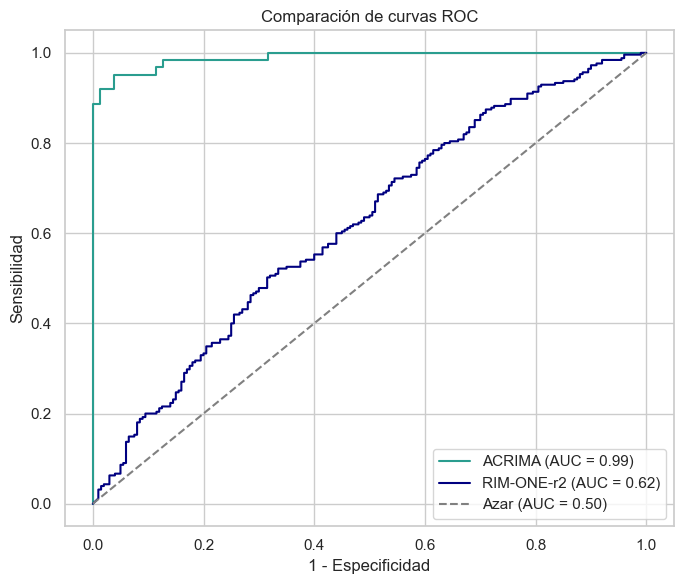

In [362]:
plt.figure(figsize=(7, 6))


plt.plot(fpr_acrima, tpr_acrima, label=f'ACRIMA (AUC = {auc_acrima:.2f})', color='#2a9d8f')


plt.plot(fpr_rimone, tpr_rimone, label=f'RIM-ONE-r2 (AUC = {auc_rimone:.2f})', color='navy')

# Línea de azar
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Azar (AUC = 0.50)')

# Configuración
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.title('Comparación de curvas ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

MCC ACRIMA  @0.5 = 0.832
MCC RIM-ONE @0.5 = 0.056


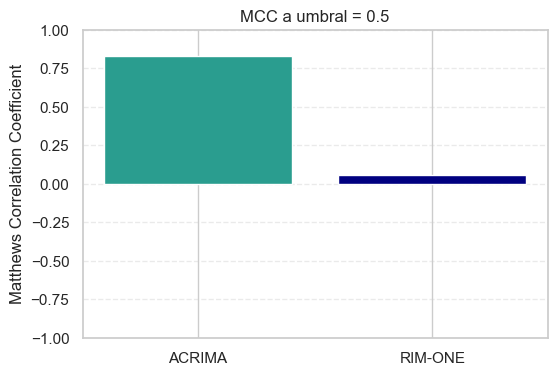

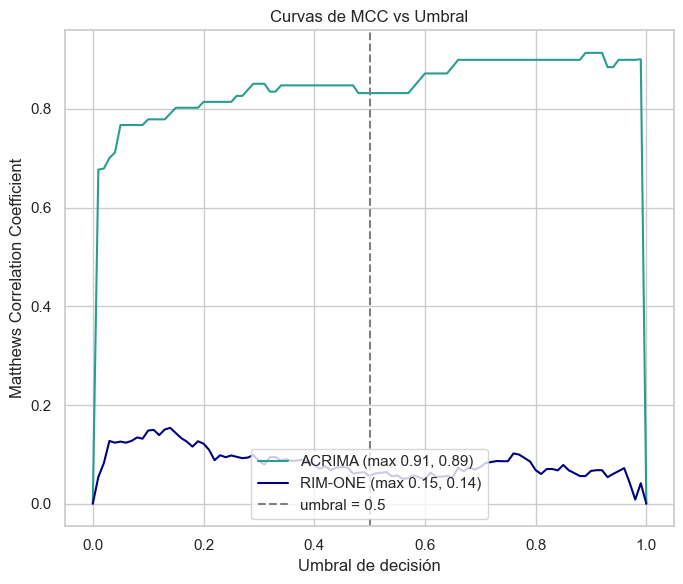

In [365]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

# --- Asume que ya tienes definidos:
# y_true_acrima, y_pred_acrima  # y_pred_* son probabilidades (float entre 0 y 1)
# y_true_rimone, y_pred_rimone

# Opción 1: MCC puntual a umbral = 0.5
mcc_acrima = matthews_corrcoef(y_true_acrima, y_pred_acrima > 0.5)
mcc_rimone = matthews_corrcoef(y_true_rimone, y_pred_rimone > 0.5)

print(f"MCC ACRIMA  @0.5 = {mcc_acrima:.3f}")
print(f"MCC RIM-ONE @0.5 = {mcc_rimone:.3f}")

plt.figure(figsize=(6,4))
plt.bar(
    ['ACRIMA','RIM-ONE'],
    [mcc_acrima, mcc_rimone],
    color=['#2a9d8f','navy']
)
plt.ylim(-1,1)
plt.ylabel('Matthews Correlation Coefficient')
plt.title('MCC a umbral = 0.5')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


# Opción 2: Curvas MCC vs umbral
thresholds = np.linspace(0, 1, 101)

def mcc_curve(y_true, y_prob, thresholds):
    return [matthews_corrcoef(y_true, y_prob > t) for t in thresholds]

mccs_acrima = mcc_curve(y_true_acrima, y_pred_acrima, thresholds)
mccs_rimone = mcc_curve(y_true_rimone, y_pred_rimone, thresholds)

max_thr_acrima  = thresholds[np.argmax(mccs_acrima)]
max_mcc_acrima  = max(mccs_acrima)
max_thr_rimone  = thresholds[np.argmax(mccs_rimone)]
max_mcc_rimone  = max(mccs_rimone)

plt.figure(figsize=(7,6))
plt.plot(thresholds, mccs_acrima, label=f'ACRIMA (max {max_mcc_acrima:.2f}, {max_thr_acrima:.2f})', color='#2a9d8f')
plt.plot(thresholds, mccs_rimone, label=f'RIM-ONE (max {max_mcc_rimone:.2f}, {max_thr_rimone:.2f})', color='navy')
plt.axvline(0.5, linestyle='--', color='gray', label='umbral = 0.5')
plt.xlabel('Umbral de decisión')
plt.ylabel('Matthews Correlation Coefficient')
plt.title('Curvas de MCC vs Umbral')
plt.legend(loc='lower center')
plt.grid(True)
plt.tight_layout()
plt.show()
